<a href="https://colab.research.google.com/github/John-Ragland/ee511_assignments/blob/main/project/doruk_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
* [Setup & Data Retrieval](#set-up)
* [Baseline Models](#baseline)
  + [Vegas Baseline](#vegas) : Spread RMSE=15.44, Winner acc=74.86%
  + [Simple Linear Baseline](#linear-model) : Spread RMSE=15.78, Winner acc=81.28%
* [More Complex Models](#complex-models)
  + [Complex Linear Model](#linear-complex) : Spread RMSE=14.25, Winner acc=%81.56
  + [L1 Regularization](#l1) : Spread RMSE = 3.64, Winner acc = 59.97%
  + [Random Forest Model](#random-forest) : Winner acc=~84%
* [Neural Networks](#nn)
  + [Linear NN for Predicting the Spread](#linear-spread-nn) : Spread RMSE=21.63
  + [Linear NN for Predicting the Winner](#linear-winner-nn) : Winner acc=67.11%



# TODOs

*   Find the most optimal hyperparameter for each model
*   Try different training loss function for neural nets
*   Implement cross validation for all models
*   Get winning percentage difference prior to the game
*   Add the "Advanced team metrics by season" table into data





# Setup the Notebook and Get Data<a name="set-up"></a>

In [59]:
# Suppress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold

In [ ]:
# look_back = 3 # games
def get_data(data_type, start_year, end_year=2020, week=None):
    website = 'https://api.collegefootballdata.com/' + data_type
    frames = []
    for year in range(start_year, end_year+1):
        url = website + '?year=%d' % year
        if week:
          # start = max(week - look_back, 1)
          # url += '&startWeek=%d' % start
          url += '&endWeek=%d' % week
        frames.append(pd.read_json(url))
    return pd.concat(frames)

In [ ]:
def get_weekly_stats(start_year):
  frames = []
  for week in range(1, 16):
    week_frame = get_data('stats/season', start_year, week=week)
    week_frame['week'] = week+1
    frames.append(week_frame)
  return pd.concat(frames)

In [ ]:
# collect the data
begin = 2013
original_stats = get_weekly_stats(begin)
original_games = get_data('games', begin)
original_records = get_data('records', begin)
original_teams = pd.read_json('https://api.collegefootballdata.com/teams')
original_spread = get_data('metrics/wp/pregame', begin)
original_rankings = get_data('rankings', begin)

In [ ]:
# get the games and calculate spread (result)
games = original_games
games = games.assign(result = (games.home_points-games.away_points))
games = games.loc[:, games.columns.intersection(['id', 'season', 'week', 'home_team', 'away_team', 'result', 'excitement_index'])]

# add pregame predictions
spreads = original_spread.loc[:, original_spread.columns.intersection(['gameId', 'spread', 'homeWinProb'])]
spreads.spread *= -1
games = pd.merge(games, spreads, how='left', left_on=['id'], right_on=['gameId']).drop(['gameId'], axis=1)

# get winning percentages from the current season
# TODO: get this for upto the current games that season
records = original_records
records = records.assign(total_games = [d.get('games') for d in records.total])
records = records.assign(total_wins = [d.get('wins') for d in records.total])
records = records.loc[:, records.columns.intersection(['year', 'team', 'total_games', 'total_wins'])]

# add winning percentage difference
games = pd.merge(games, records.rename(columns={'total_games': 'home_total_games', 'total_wins': 'home_wins'}), how='left', left_on=['season', 'home_team'], right_on=['year', 'team']).drop(['year', 'team'], axis=1)
games = pd.merge(games, records.rename(columns={'total_games': 'away_total_games', 'total_wins': 'away_wins'}), how='left', left_on=['season', 'away_team'], right_on=['year', 'team']).drop(['year', 'team'], axis=1)
games = games.assign(win_difference = ((games.home_wins / games.home_total_games)-(games.away_wins / games.away_total_games)))
games = games.drop(['home_wins', 'away_wins'], axis=1)
games = games.dropna()
games = games.drop(columns=['home_total_games', 'away_total_games'])

# get the list of stats
stats = original_stats
stats = stats.drop(columns=['conference'])
w = stats.loc[(stats.team == 'Washington') & (stats.season == begin)]
stat_cols = w.statName.to_list()
stat_cols = list(set(stat_cols)) # remove duplicates
stat_cols.sort()
stat_cols.remove('games')
print(stat_cols)

# add each stat of both teams
s = stats.loc[(stats.statName == 'games')]
s = s.drop(columns=['statName'])
games = pd.merge(games, s.rename(columns={'statValue': 'home_games'}), how='left', left_on=['season', 'home_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
games = pd.merge(games, s.rename(columns={'statValue': 'away_games'}), how='left', left_on=['season', 'away_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)

for stat in stat_cols:
  s = stats.loc[(stats.statName == stat)]
  s = s.drop(columns=['statName'])
  games = pd.merge(games, s.rename(columns={'statValue': 'home_'+stat}), how='left', left_on=['season', 'home_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
  games = pd.merge(games, s.rename(columns={'statValue': 'away_'+stat}), how='left', left_on=['season', 'away_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
  games = games.fillna(0)
  games[stat] = (games['home_'+stat]/games.home_games) - (games['away_'+stat]/games.away_games)
  games = games.drop(columns=['home_'+stat, 'away_'+stat])

games = games.fillna(0)

['firstDowns', 'fourthDownConversions', 'fourthDowns', 'fumblesLost', 'fumblesRecovered', 'interceptionTDs', 'interceptionYards', 'interceptions', 'kickReturnTDs', 'kickReturnYards', 'kickReturns', 'netPassingYards', 'passAttempts', 'passCompletions', 'passesIntercepted', 'passingTDs', 'penalties', 'penaltyYards', 'possessionTime', 'puntReturnTDs', 'puntReturnYards', 'puntReturns', 'rushingAttempts', 'rushingTDs', 'rushingYards', 'thirdDownConversions', 'thirdDowns', 'totalYards', 'turnovers']


In [ ]:
# create the table for total points a team scored for and against before a given week
points_per_game = original_teams.loc[:, original_teams.columns.intersection(['school'])]
points_per_game['year'] = 2020
one_season = points_per_game.copy()
for year in range(2004, 2020):
  temp = one_season.copy()
  temp['year'] = year
  points_per_game = pd.concat([points_per_game, temp], ignore_index=True)

points_per_game[('points_for_week1')] = 0.0
points_per_game[('points_against_week1')] = 0.0
scores = original_games.loc[:, original_games.columns.intersection(['season', 'week', 'home_team', 'away_team', 'home_points', 'away_points'])]
scores['week'] += 1
for week in range(2, 16):
  this_scores = scores.loc[scores.week == week]
  this_scores = this_scores.rename(columns={'home_points': ('points_for_week%d' % week), 'away_points': ('points_against_week%d' % week)})
  points_per_game = pd.merge(points_per_game, this_scores, how='left', left_on=['school', 'year'], right_on=['home_team', 'season']).drop(['home_team', 'away_team', 'season', 'week'], axis=1)
  this_scores = scores.loc[scores.week == week]
  this_scores = this_scores.rename(columns={'away_points': ('points_for_week%d' % week), 'home_points': ('points_against_week%d' % week)})
  points_per_game = pd.merge(points_per_game, this_scores, how='left', left_on=['school', 'year'], right_on=['away_team', 'season']).drop(['home_team', 'away_team', 'season', 'week'], axis=1)
  points_per_game = points_per_game.fillna(0)
  points_per_game[('points_for_week%d' % week)] = points_per_game[('points_for_week%d_x' % week)] + points_per_game[('points_for_week%d_y' % week)]
  points_per_game[('points_against_week%d' % week)] = points_per_game[('points_against_week%d_x' % week)] + points_per_game[('points_against_week%d_y' % week)]
  points_per_game = points_per_game.drop(columns=[('points_for_week%d_x' % week), ('points_for_week%d_y' % week), ('points_against_week%d_x' % week), ('points_against_week%d_y' % week)])

for week in range(2, 16):
  points_per_game[('points_for_week%d' % week)] += points_per_game[('points_for_week%d' % (week-1))]
  points_per_game[('points_against_week%d' % week)] += points_per_game[('points_against_week%d' % (week-1))]

for week in range(1,16):
  points = points_per_game.loc[:, points_per_game.columns.intersection(['year', 'school', ('points_for_week%d' % week), ('points_against_week%d' % week)])]
  points = points.rename(columns={('points_for_week%d' % week): 'home_for', ('points_against_week%d' % week): 'home_against'})
  points['week'] = week
  games = pd.merge(games, points, how='left', left_on=['home_team', 'season', 'week'], right_on=['school', 'year', 'week']).drop(['school', 'year'], axis=1)
  points = points.rename(columns={'home_for': 'away_for', 'home_against': 'away_against'})
  games = pd.merge(games, points, how='left', left_on=['away_team', 'season', 'week'], right_on=['school', 'year', 'week']).drop(['school', 'year'], axis=1)
  if (week > 1):
    games['home_for'] = games['home_for_x'].fillna(0) + games['home_for_y'].fillna(0)
    games['home_against'] = games['home_against_x'].fillna(0) + games['home_against_y'].fillna(0)
    games['away_for'] = games['away_for_x'].fillna(0) + games['away_for_y'].fillna(0)
    games['away_against'] = games['away_against_x'].fillna(0) + games['away_against_y'].fillna(0)
    games = games.drop(columns=['home_for_x', 'home_for_y', 'home_against_x', 'home_against_y', 'away_for_x', 'away_for_y', 'away_against_x', 'away_against_y'])

games['home_for'] /= games['home_games']
games['home_against'] /= games['home_games']
games['away_for'] /= games['away_games']
games['away_against'] /= games['away_games']
games = games.fillna(0)

# points_per_game.loc[points_per_game.school == 'Washington']

In [ ]:
# add ap-top 25 rankings for each team, -1 if not ranked
rankings = original_rankings.drop(columns = ['seasonType'])
rankings['rank1_name'] = [d[0].get('poll') for d in rankings.polls]
rankings['rank1_ranks'] = [d[0].get('ranks') for d in rankings.polls]
rankings['rank2_name'] = [d[1].get('poll') for d in rankings.polls]
rankings['rank2_ranks'] = [d[1].get('ranks') for d in rankings.polls]
rankings.loc[rankings['rank1_name'] == 'AP Top 25', 'ap'] = rankings.loc[rankings['rank1_name'] == 'AP Top 25'].rank1_ranks
rankings.loc[rankings['rank2_name'] == 'AP Top 25', 'ap'] = rankings.loc[rankings['rank2_name'] == 'AP Top 25'].rank2_ranks
rankings = rankings.drop(columns=['rank1_name', 'rank2_name', 'rank1_ranks', 'rank2_ranks', 'polls'])
rankings = rankings.reset_index(drop=True)
rankings = rankings.explode('ap').reset_index(drop=True)
rankings['school'] = [d.get('school') for d in rankings.ap]
rankings['rank'] = [d.get('rank') for d in rankings.ap]
rankings = rankings.drop(columns=['ap'])
games = pd.merge(games, rankings.rename(columns={'rank': 'home_rank'}), how='left', left_on=['season', 'week', 'home_team'], right_on=['season', 'week', 'school']).drop(['school'], axis=1)
games = pd.merge(games, rankings.rename(columns={'rank': 'away_rank'}), how='left', left_on=['season', 'week', 'away_team'], right_on=['season', 'week', 'school']).drop(['school'], axis=1)
games = games.fillna(-1)


In [ ]:
def one_hot(column):
  column = column.reshape(-1, 1)
  enc = OneHotEncoder()
  enc.fit(column)
  return enc.transform(column).toarray()

def replace_categorical_with_one_hot(df, column):
  one_hot_matrix = one_hot(np.array(df[column]))
  _, new_cols = one_hot_matrix.shape
  for i in range(new_cols):
      df["%s_%d" % (column, i)] = one_hot_matrix[:,i]
  df = df.drop(column, 1)
  return df

In [ ]:
torch.manual_seed(0)
device = torch.device("cuda")
print('Using device', device)

Using device cuda


# Baseline Models<a name="baseline"></a>

## Vegas RMSE<a name="vegas"></a>

In [ ]:
valid = games.loc[games.season == 2019]
train = games.loc[games.season != 2019]

In [ ]:
train_in = train.spread.to_numpy()
train_out = train.result.to_numpy()
valid_in = valid.spread.to_numpy()
valid_out = valid.result.to_numpy()
baseline_model = LinearRegression().fit(train_in.reshape(-1, 1), train_out)

Vegas spread RMSE = 15.44 points
Game winner accuracy = 74.863%


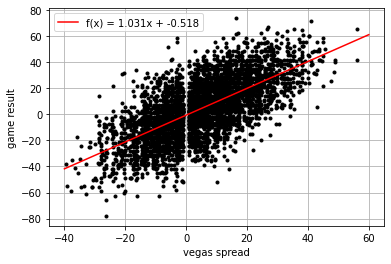

In [ ]:
x = np.linspace(-40, 60, 500)
y = baseline_model.coef_ * x + baseline_model.intercept_
y = baseline_model.predict(x.reshape(-1, 1))

plt.xlabel('vegas spread')
plt.ylabel('game result')
plt.plot(train_in, train_out, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (baseline_model.coef_, baseline_model.intercept_))
plt.legend()
plt.grid()

prediction = baseline_model.predict(valid_in.reshape(-1, 1))
print('Vegas spread RMSE = %.2f points' % mean_squared_error(valid_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1 # home win
temp_pred[temp_pred<0] = 0 # away win

temp_tru = valid_out
temp_tru[temp_tru>0] =  1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

## Simple linear baseline model<a name="simple-linear"></a>

In [ ]:
valid = games.loc[games.season == 2019]
train = games.loc[games.season != 2019]

In [ ]:
train_in = train.win_difference.to_numpy()
train_out = train.result.to_numpy()
valid_in = valid.win_difference.to_numpy()
valid_out = valid.result.to_numpy()
baseline_model = LinearRegression().fit(train_in.reshape(-1, 1), train_out)

Spread RMSE = 15.78 points
Game winner accuracy = 81.284%


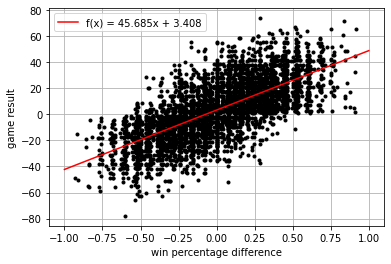

In [ ]:
x = np.linspace(-1, 1, 500)
y = baseline_model.coef_ * x + baseline_model.intercept_
y = baseline_model.predict(x.reshape(-1, 1))

plt.xlabel('win percentage difference')
plt.ylabel('game result')
plt.plot(train_in, train_out, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (baseline_model.coef_, baseline_model.intercept_))
plt.legend()
plt.grid()

prediction = baseline_model.predict(valid_in.reshape(-1, 1))
print('Spread RMSE = %.2f points' % mean_squared_error(valid_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = valid_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

# More Complex Models<a name="complex-models"></a>

## Linear model with more features<a name="linear-complex"></a>

In [ ]:
games.loc[(games.home_team == 'Washington') & (games.season == 2013)]

,id,season,week,home_team,away_team,excitement_index,result,spread,homeWinProb,win_difference,home_games,away_games,firstDowns,fourthDownConversions,fourthDowns,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,interceptions,kickReturnTDs,kickReturnYards,kickReturns,netPassingYards,passAttempts,passCompletions,passesIntercepted,passingTDs,penalties,penaltyYards,possessionTime,puntReturnTDs,puntReturnYards,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownConversions,thirdDowns,totalYards,turnovers,home_for,home_against,away_for,away_against,home_rank,away_rank
38,332430264,2013,1,Washington,Boise State,4.016148,32.0,2.5,0.558,0.076923,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,19.0
202,332710264,2013,5,Washington,Arizona,5.958433,18.0,7.0,0.660,0.076923,3.0,3.0,9.666667,-0.666667,-0.666667,0.333333,-0.333333,-1.000000,-48.666667,0.333333,0.0,32.000000,1.666667,216.666667,13.000000,13.666667,-0.666667,2.000000,8.666667,71.666667,182.666667,0.0,-26.666667,-3.666667,2.000000,-1.000000,-18.666667,2.000000,-0.666667,198.000000,0.666667,42.666667,10.000000,43.666667,8.666667,16.0,-1.0
305,332850264,2013,7,Washington,Oregon,4.255697,-21.0,-10.5,0.268,-0.153846,5.0,5.0,1.800000,-0.600000,-1.200000,0.000000,-1.400000,0.000000,-19.000000,0.200000,0.0,2.600000,0.200000,3.600000,3.400000,6.600000,0.200000,-0.600000,3.000000,22.400000,202.800000,-0.4,-37.800000,-0.600000,4.400000,-2.200000,-77.000000,2.800000,1.600000,-73.400000,0.200000,37.400000,14.800000,59.200000,11.800000,16.0,2.0
422,332990264,2013,9,Washington,California,2.546683,24.0,23.0,0.912,0.608974,7.0,7.0,0.428571,-0.857143,-1.714286,-1.000000,-0.714286,0.000000,2.857143,-0.857143,0.0,-56.000000,-2.285714,-89.857143,-18.285714,-9.142857,0.571429,0.285714,0.857143,2.714286,18.000000,0.0,-1.714286,-0.285714,9.142857,1.571429,105.428571,1.000000,-2.857143,15.571429,-1.857143,33.571429,24.571429,23.714286,44.428571,-1.0,-1.0
515,333130264,2013,11,Washington,Colorado,1.934312,52.0,27.0,0.944,0.358974,8.0,8.0,5.750000,0.000000,0.000000,0.000000,-0.500000,-0.250000,-21.375000,-0.750000,0.0,-14.625000,-0.250000,34.625000,0.375000,2.250000,0.000000,0.500000,3.750000,31.750000,35.125000,0.0,2.750000,0.625000,9.875000,1.375000,89.500000,2.625000,0.875000,124.125000,-0.750000,34.500000,23.625000,26.375000,38.125000,-1.0,-1.0
635,333330264,2013,14,Washington,Washington State,5.738191,10.0,14.5,0.803,0.230769,11.0,11.0,2.454545,-0.545455,-0.545455,-0.181818,-0.363636,-0.181818,-9.181818,-1.363636,0.0,-16.454545,-0.636364,-92.545455,-24.818182,-14.909091,-0.090909,-0.454545,3.000000,29.727273,0.000000,0.0,-7.818182,-0.454545,28.454545,1.909091,184.818182,1.909091,0.454545,92.272727,-1.545455,39.545455,24.000000,31.000000,31.636364,-1.0,-1.0


In [60]:
valid = games.loc[games.season == 2019]
train = games.loc[games.season != 2019]

valid = valid.drop(columns=['season', 'id', 'home_team', 'away_team'])
valid = valid.fillna(0)
train = train.drop(columns=['season', 'id', 'home_team', 'away_team'])
train = train.fillna(0)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result
model = LinearRegression().fit(train_in, train_out)

In [61]:
prediction = model.predict(valid_in)
print('Spread RMSE = %.2f points' % mean_squared_error(valid_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = valid_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

Spread RMSE = 14.25 points
Game winner accuracy = 81.557%


## Linear model with L1 Regularization<a name="l1"></a>

In [80]:
alphas = np.linspace(1,1000,50)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_valid = []
mse_train = []
num_nonzero = []

for alpha in alphas:
    large_model_lasso = Lasso(alpha=alpha, random_state=77)
    mse_kfold = []
    # Iterate through all folds
    for train_index, test_index in kf.split(train_in):        
        large_model_lasso.fit(train_in.iloc[train_index], train_out.iloc[train_index])
        kf_test_pred = large_model_lasso.predict(train_in.iloc[test_index])
        error = mean_squared_error(train_out.iloc[test_index], kf_test_pred, squared=False)
        mse_kfold.append(error)

    # count number of nonzero coefficients
    num_nonzero.append(np.sum(large_model_lasso.coef_ != 0))
    
    # create error arrays
    mse_train.append(np.mean(mse_kfold))
    large_model_lasso.fit(train_in, train_out)
    pred_valid = large_model_lasso.predict(valid_in)
    mse_valid.append(mean_squared_error(valid_out, pred_valid, squared=False))

Optimum Alpha at 755.3469387755102


(0.0, 50.0)

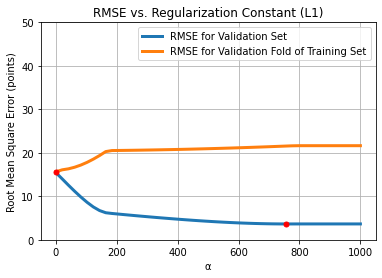

In [88]:
best_alpha = alphas[np.argmin(mse_valid)]
print(f'Optimum Alpha at {best_alpha}')
plt.plot(alphas,mse_valid, linewidth=3)
plt.plot(alphas,mse_train, linewidth=3)
plt.plot(best_alpha,np.min(mse_valid),'r.',markersize=10)
plt.plot(alphas[np.argmin(mse_train)],np.min(mse_train),'r.',markersize=10)

plt.legend(['RMSE for Validation Set','RMSE for Validation Fold of Training Set'])
plt.xlabel('α')
plt.ylabel('Root Mean Square Error (points)')
plt.title('RMSE vs. Regularization Constant (L1)')
plt.grid()
plt.ylim([0, 50])

In [97]:
lasso_model = Lasso(alpha=best_alpha, random_state=77)
lasso_model.fit(train_in, train_out)
prediction = lasso_model.predict(valid_in)
print('Spread RMSE = %.2f points' % mean_squared_error(valid_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = valid_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))
# THIS MODEL OVERFIT! BAD RESULT!
# CONCLUSION: LASSO DID NOT IMPROVE RESULTS

Spread RMSE = 3.64 points
Game winner accuracy = 59.973%


## Random Forest<a name="random-forest"></a>

In [ ]:
valid = games.loc[games.season == 2019]
train = games.loc[games.season != 2019]

valid = valid.drop(columns=['season', 'id', 'home_team', 'away_team'])
valid = valid.fillna(0)
train = train.drop(columns=['season', 'id', 'home_team', 'away_team'])
train = train.fillna(0)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result

train_out_winner = train_out
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_out_winner = valid_out
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

In [ ]:
MAX_DEPTH = 15
random_model = RandomForestClassifier(max_depth=MAX_DEPTH)
random_model.fit(train_in, train_out_winner)
print('Game winner accuracy = %.3f%%' % ((np.sum(random_model.predict(valid_in)==valid_out_winner) / len(valid_out_winner))*100.0))

Game winner accuracy = 84.016%


# Neural Networks<a name="nn"></a>

## Linear Neural Net for Predicting the Spread<a name="linear-spread-nn"></a>

In [ ]:
# Hyperparameters
BATCH_SIZE = 600
EPOCHS = 100
LEARNING_RATE = 0.005

In [ ]:
# Setup the data
valid = games.loc[games.season == 2019]
train = games.loc[games.season != 2019]

valid = valid.drop(columns=['season', 'id', 'home_team', 'away_team'])
valid = valid.fillna(0)
train = train.drop(columns=['season', 'id', 'home_team', 'away_team'])
train = train.fillna(0)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out.to_numpy(), dtype=torch.float, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

data_valid_vals = torch.tensor(valid_in.to_numpy(), dtype=torch.float, device=device)
data_valid_labels = torch.tensor(valid_out.to_numpy(), dtype=torch.float, device=device)
data_valid = TensorDataset(data_train_vals, data_train_labels)
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)

In [ ]:
def train(model, device, train_loader, optimizer, epochs, criterion, verbose=False):
  for epoch in range(epochs):
    model.train()
    batch_loss = 0
    for data, label in train_loader:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if verbose:
      print('Train Epoch: %d  \tLoss: %.6f' % (epoch, np.sqrt(batch_loss/len(train_loader))))

def test(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      test_loss += criterion(output, label).item()
  print('Test set: Average loss: %.4f' % np.sqrt(test_loss/len(test_loader)))

  return test_loss

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 500).cuda()
        self.fc2 = nn.Linear(500, 200).cuda()
        self.fc3 = nn.Linear(200, 50).cuda()
        self.fc4 = nn.Linear(50, 10).cuda()
        self.fc5 = nn.Linear(10, 1).cuda()
        # self.fc = nn.Linear(input_size, 1).cuda()
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x))
        x = self.fc5(x)
        return x
        # return self.fc(x)

model = Net(np.shape(train_in.to_numpy())[1])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [ ]:
train(model, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

Train Epoch: 0  	Loss: 22.078227
Train Epoch: 1  	Loss: 22.044913
Train Epoch: 2  	Loss: 22.024239
Train Epoch: 3  	Loss: 22.040351
Train Epoch: 4  	Loss: 22.027571
Train Epoch: 5  	Loss: 21.977918
Train Epoch: 6  	Loss: 22.018238
Train Epoch: 7  	Loss: 21.972643
Train Epoch: 8  	Loss: 21.972460
Train Epoch: 9  	Loss: 21.982245
Train Epoch: 10  	Loss: 21.941217
Train Epoch: 11  	Loss: 21.921824
Train Epoch: 12  	Loss: 21.882554
Train Epoch: 13  	Loss: 21.890300
Train Epoch: 14  	Loss: 21.876700
Train Epoch: 15  	Loss: 21.885297
Train Epoch: 16  	Loss: 21.919260
Train Epoch: 17  	Loss: 21.847682
Train Epoch: 18  	Loss: 21.866933
Train Epoch: 19  	Loss: 21.878307
Train Epoch: 20  	Loss: 21.785236
Train Epoch: 21  	Loss: 21.836362
Train Epoch: 22  	Loss: 21.780742
Train Epoch: 23  	Loss: 21.819541
Train Epoch: 24  	Loss: 21.795496
Train Epoch: 25  	Loss: 21.810168
Train Epoch: 26  	Loss: 21.782397
Train Epoch: 27  	Loss: 21.830589
Train Epoch: 28  	Loss: 21.816156
Train Epoch: 29  	Loss: 

In [ ]:
result = test(model, device, valid_loader, criterion)

Test set: Average loss: 21.6336


## Linear Neural Net for Predicting the Winner<a name="linear-winner-nn"></a>

In [ ]:
BATCH_SIZE = 200
EPOCHS = 100
LEARNING_RATE = 0.005

In [ ]:
valid = games.loc[games.season == 2019]
train = games.loc[games.season != 2019]

valid = valid.drop(columns=['season', 'id', 'home_team', 'away_team'])
valid = valid.fillna(0)
train = train.drop(columns=['season', 'id', 'home_team', 'away_team'])
train = train.fillna(0)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result

train_out_winner = train_out
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_out_winner = valid_out
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out_winner.to_numpy(), dtype=torch.long, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

data_valid_vals = torch.tensor(valid_in.to_numpy(), dtype=torch.float, device=device)
data_valid_labels = torch.tensor(valid_out_winner.to_numpy(), dtype=torch.long, device=device)
data_valid = TensorDataset(data_train_vals, data_train_labels)
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)

In [ ]:
def trainWinner(model, device, train_loader, optimizer, epochs, criterion, verbose=False):
  for epoch in range(epochs):
    model.train()
    batch_loss = 0
    for data, label in train_loader:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if verbose:
      print('Train Epoch: %d  \tLoss: %.6f' % (epoch, np.sqrt(batch_loss/len(train_loader))))

def testWinner(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  wrong = 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      test_loss += criterion(output, label).item()
      correct += torch.sum(torch.argmax(output, dim=1) == label)
      wrong += torch.sum(torch.argmax(output, dim=1) != label)
  print('Test set: Average loss: %.4f' % np.sqrt(test_loss/len(test_loader)))
  print('Accuracy: %.3f%%' % (correct*100/(correct+wrong)))

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 500).cuda()
        self.fc2 = nn.Linear(500, 200).cuda()
        self.fc3 = nn.Linear(200, 50).cuda()
        self.fc4 = nn.Linear(50, 10).cuda()
        self.fc5 = nn.Linear(10, 3).cuda()
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x))
        x = self.fc5(x)
        return x

modelWinner = Net(np.shape(train_in.to_numpy())[1])

In [ ]:
optimizer = torch.optim.Adam(modelWinner.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainWinner(modelWinner, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

Train Epoch: 0  	Loss: 0.973981
Train Epoch: 1  	Loss: 0.918567
Train Epoch: 2  	Loss: 0.886359
Train Epoch: 3  	Loss: 0.856260
Train Epoch: 4  	Loss: 0.842172
Train Epoch: 5  	Loss: 0.834567
Train Epoch: 6  	Loss: 0.829575
Train Epoch: 7  	Loss: 0.821116
Train Epoch: 8  	Loss: 0.817322
Train Epoch: 9  	Loss: 0.812353
Train Epoch: 10  	Loss: 0.813504
Train Epoch: 11  	Loss: 0.810675
Train Epoch: 12  	Loss: 0.808017
Train Epoch: 13  	Loss: 0.807920
Train Epoch: 14  	Loss: 0.805367
Train Epoch: 15  	Loss: 0.802529
Train Epoch: 16  	Loss: 0.800317
Train Epoch: 17  	Loss: 0.798140
Train Epoch: 18  	Loss: 0.798323
Train Epoch: 19  	Loss: 0.799412
Train Epoch: 20  	Loss: 0.798321
Train Epoch: 21  	Loss: 0.798014
Train Epoch: 22  	Loss: 0.793818
Train Epoch: 23  	Loss: 0.794956
Train Epoch: 24  	Loss: 0.794472
Train Epoch: 25  	Loss: 0.800490
Train Epoch: 26  	Loss: 0.799416
Train Epoch: 27  	Loss: 0.819572
Train Epoch: 28  	Loss: 0.805293
Train Epoch: 29  	Loss: 0.799915
Train Epoch: 30  	Lo

In [ ]:
testWinner(modelWinner, device, valid_loader, criterion)

Test set: Average loss: 0.7949
Accuracy: 67.117%
